In [1]:
%cd /mnt/home/zzhang/ceph/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import pandas as pd
from Bio import pairwise2
from Bio.Seq import Seq
from sklearn.preprocessing import scale
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xumg4m_a because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# pre-defined letter index
build_indel = True
# match : 4 letters, 0-3
ltidx = {(x,x):i for i,x in enumerate('ACGT')}
# substitution : x->y, 4-7
ltidx.update({(x,y):(ltidx[(x,x)], i+4) for x in 'ACGT' for i, y in enumerate('ACGT') if y!=x })
if build_indel:
    # insertion : NA->y, 8-11
    ltidx.update({('-', x):i+8 for i,x in enumerate('ACGT')})
    # deletion : x->NA, 12
    ltidx.update({(x,'-'):(ltidx[(x,x)], 12) for i,x in enumerate('ACGT')})
ltidx

{('A', 'A'): 0,
 ('C', 'C'): 1,
 ('G', 'G'): 2,
 ('T', 'T'): 3,
 ('A', 'C'): (0, 5),
 ('A', 'G'): (0, 6),
 ('A', 'T'): (0, 7),
 ('C', 'A'): (1, 4),
 ('C', 'G'): (1, 6),
 ('C', 'T'): (1, 7),
 ('G', 'A'): (2, 4),
 ('G', 'C'): (2, 5),
 ('G', 'T'): (2, 7),
 ('T', 'A'): (3, 4),
 ('T', 'C'): (3, 5),
 ('T', 'G'): (3, 6),
 ('-', 'A'): 8,
 ('-', 'C'): 9,
 ('-', 'G'): 10,
 ('-', 'T'): 11,
 ('A', '-'): (0, 12),
 ('C', '-'): (1, 12),
 ('G', '-'): (2, 12),
 ('T', '-'): (3, 12)}

In [4]:
def make_alignment(df, maxlen=25):
    ref = Seq(df.iloc[0]['sequence'])
    ref = ref[::-1]
    alignments = []
    for seq in df['sequence']:
        alt = Seq(seq)
        alt = alt[::-1]
        # m: A match score is the score of identical chars, otherwise mismatch score
        # d: The sequences have different open and extend gap penalties.
        aln = pairwise2.align.localxd(ref, alt, -1, -0.1, -1, 0)
        if len(aln[0][0]) > maxlen: # increase gap open penalty to avoid too many gaps
            aln = pairwise2.align.localxd(ref, alt, -5, -0.1, -5, 0)
            if len(aln[0][0]) > maxlen:
                aln = [(ref, alt)]
        alignments.append(aln[0])
    return alignments


def featurize_alignment(alignments, maxlen=25, verbose=False):
    mats = []
    for j, aln in enumerate(alignments):
        if build_indel:
            fea = np.zeros((maxlen, 13))
        else:
            fea = np.zeros((maxlen, 8))
            
        assert len(aln[0]) <= maxlen, "alignment {} larger than maxlen: {}".format(j, aln)
        if build_indel is False and ('-' in aln[0] or '-' in aln[1]):
            mats.append(None)
        else:
            p = 0
            for i in range(len(aln[0])):
                k = (aln[0][i], aln[1][i])
                #fea[p, ltidx[k]] = 1
                #p += 1
                if k[0]=="-" or k[1]=="-": # is indel
                    #if build_indel:
                    #    fea[p, ltidx[k]] = 1
                    #    p += 1
                    if k[1]=="-": # target has gap - deletion
                        fea[p, ltidx[k]] = 1
                        p += 1
                    else:           # gRNA has gap - insertion
                        fea[max(0,p-1), ltidx[k]] = 1
                else:
                    fea[p, ltidx[k]] = 1
                    p += 1
                if verbose: print(k, p)
            mats.append(fea)
    return mats

def get_cleavage_specificity(df, label_cols):
    k_m = df.query('descriptor=="Matched"')[label_cols].to_numpy()
    df[['%s_specificity'%x for x in label_cols]] = k_m - df[label_cols]
    return df

In [5]:
#featurize_alignment([alns1[112]], verbose=True)
#featurize_alignment([alns1[72]], verbose=True)

In [6]:
# read
df1 = pd.read_csv("./data/sgRNA_1.csv")
df2 = pd.read_csv("./data/sgRNA_2.csv")
df1 = df1.dropna()
df2 = df2.dropna()
dm = df1[['wtCas9_cleave_rate_log']].join(df2[['wtCas9_cleave_rate_log']], lsuffix=".gRNA1", rsuffix=".gRNA2")

# log, or log10??
dm['1.log10'] = np.log10(dm['wtCas9_cleave_rate_log.gRNA1'])
dm['1.log'] = np.log(dm['wtCas9_cleave_rate_log.gRNA1'])
dm = np.maximum(dm, -5)
dm.corr()

,wtCas9_cleave_rate_log.gRNA1,wtCas9_cleave_rate_log.gRNA2,1.log10,1.log
wtCas9_cleave_rate_log.gRNA1,1.000000,0.593840,0.658976,0.967477
wtCas9_cleave_rate_log.gRNA2,0.593840,1.000000,0.788897,0.613920
1.log10,0.658976,0.788897,1.000000,0.696478
1.log,0.967477,0.613920,0.696478,1.000000


In [7]:
print("df1", df1.shape)
print("df2", df1.shape)

aba_cols = ['wtCas9_ndABA', 
    'Cas9_enh_ndABA',
    'Cas9_hypa_ndABA', 
    'Cas9_HF1_ndABA', ]
cl_cols = ['wtCas9_cleave_rate_log',
    'Cas9_enh_cleave_rate_log',
    'Cas9_hypa_cleave_rate_log',
    'Cas9_HF1_cleave_rate_log',
]

# THIS IS IMPORTANT: df1 cleave rates seems to be non-negative, thus must be non-log
# Or alternatively, exponieate by base 10
log_fn = np.log10
print("df1\n min=", df1[cl_cols[0]].min(), '; mean=', df1[cl_cols[0]].mean(), '; max=', df1[cl_cols[0]].max())
print("df2\n min=", df2[cl_cols[0]].min(), '; mean=', df2[cl_cols[0]].mean(), '; max=', df2[cl_cols[0]].max())
df1[cl_cols] = log_fn(df1[cl_cols])
print("df1, after log10\n min=", df1[cl_cols[0]].min(), '; mean=', df1[cl_cols[0]].mean(), '; max=', df1[cl_cols[0]].max())

# clip at limit of detection
LOD = 1e-5
print("CLIP LOWER BOUND")
print(f"clipped n={(df1[cl_cols]<log_fn(LOD)).sum()} for gRNA1")
print(f"clipped n={(df2[cl_cols]<log_fn(LOD)).sum()} for gRNA2")
df1[cl_cols] = np.maximum(df1[cl_cols], log_fn(LOD))
df2[cl_cols] = np.maximum(df2[cl_cols], log_fn(LOD))
#LOD = 1e-1
#print("CLIP UPPER BOUND")
#print(f"clipped n={(df1[cl_cols]>log_fn(LOD)).sum()} for gRNA1")
#print(f"clipped n={(df2[cl_cols]>log_fn(LOD)).sum()} for gRNA2")
#df1[cl_cols] = np.minimum(df1[cl_cols], log_fn(LOD))
#df2[cl_cols] = np.minimum(df2[cl_cols], log_fn(LOD))


df1 = get_cleavage_specificity(df1, cl_cols)
df2 = get_cleavage_specificity(df2, cl_cols)

# convert
alns1 = make_alignment(df1)
alns2 = make_alignment(df2)
mats1 = featurize_alignment(alns1)
mats2 = featurize_alignment(alns2)

val_idx1 = [i for i in range(len(mats1)) if mats1[i] is not None]
val_idx2 = [i for i in range(len(mats2)) if mats2[i] is not None]

label_cols = cl_cols + ['%s_specificity'%x for x in cl_cols] + aba_cols
label1 = df1[label_cols].to_numpy()[val_idx1]
label2 = df2[label_cols].to_numpy()[val_idx2]
mats1 = np.array([mats1[i] for i in val_idx1])
mats2 = np.array([mats2[i] for i in  val_idx2])
mats = np.concatenate([mats1, mats2])
labels = np.concatenate([label1, label2])

# sanity check
#if not build_indel: # This becomes true even with build_indel now.
for i in range(len(mats)):
    assert sum(mats[i][-1]) == 0, i
    assert sum(mats[i][-2]) == 0, i
    assert sum(mats[i][-3]) != 0, i # no consecutive two indels
#mats = mats[:, 0:23, :]

print(mats.shape)
print(labels.shape)

# save
np.save("data/compiled_X.npy", mats)
np.save("data/compiled_Y.npy", labels)

# save separately
#np.save("data/compiled_X_1.npy", mats1[:, :, 4:])
np.save("data/compiled_X_1.npy", mats1[:, :, :])
np.save("data/compiled_Y_1.npy", label1)
#np.save("data/compiled_X_2.npy", mats2[:, :, 4:])
np.save("data/compiled_X_2.npy", mats2[:, :, :])
np.save("data/compiled_Y_2.npy", label2)


with open("data/x_col_annot.txt", 'w') as f:
    f.write("\n".join([str(x) for x in ltidx]))

with open("data/y_col_annot.txt", 'w') as f:
    f.write("\n".join(label_cols))
                                    

df1 (6988, 18)
df2 (6988, 18)
df1
 min= 5e-324 ; mean= 0.006085037011996977 ; max= 0.280060372
df2
 min= -323.3062153 ; mean= -10.181011294439116 ; max= -0.405436766
df1, after log10
 min= -323.3062153431158 ; mean= -4.760351370590888 ; max= -0.5527483386568958
CLIP LOWER BOUND
clipped n=wtCas9_cleave_rate_log       2901
Cas9_enh_cleave_rate_log     5269
Cas9_hypa_cleave_rate_log    4616
Cas9_HF1_cleave_rate_log     5157
dtype: int64 for gRNA1
clipped n=wtCas9_cleave_rate_log       4116
Cas9_enh_cleave_rate_log     5592
Cas9_hypa_cleave_rate_log    5021
Cas9_HF1_cleave_rate_log     4929
dtype: int64 for gRNA2
(13993, 25, 13)
(13993, 12)


In [8]:
df1.iloc[90]

sequence                                 AGACGCATAAAGATGAGACGCTGG
descriptor                                                  21A20
wtCas9_ndABA                                            -0.012394
wtCas9_ndABA_unc                                         0.013088
wtCas9_cleave_rate_log                                  -0.860232
wtCas9_cleave_rate_log_unc                               0.070048
Cas9_enh_ndABA                                           -0.02086
Cas9_enh_ndABA_unc                                       0.011935
Cas9_enh_cleave_rate_log                                -1.021463
Cas9_enh_cleave_rate_log_unc                             0.072422
Cas9_hypa_ndABA                                         -0.011645
Cas9_hypa_ndABA_unc                                      0.025046
Cas9_hypa_cleave_rate_log                               -0.996414
Cas9_hypa_cleave_rate_log_unc                            0.065933
Cas9_HF1_ndABA                                          -0.011075
Cas9_HF1_n

In [9]:
mats[90]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 

Text(0, 0.5, 'sgRNA 2')

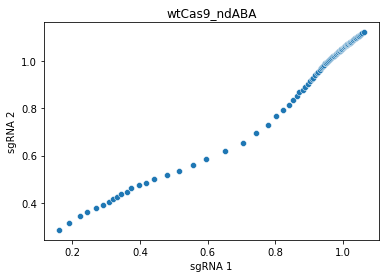

In [10]:
feat = 'wtCas9_ndABA'
ax = sns.scatterplot(
    np.percentile(df1[feat], np.arange(5,95,1)),
    np.percentile(df2[feat], np.arange(5,95,1)),
)
ax.set_title(feat)
ax.set_xlabel('sgRNA 1')
ax.set_ylabel('sgRNA 2')

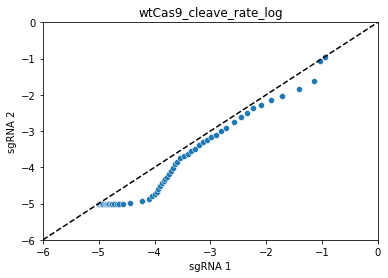

In [11]:
feat = 'wtCas9_cleave_rate_log'
ax = sns.scatterplot(
    np.percentile(df1[feat], np.arange(1,99,1)),
    np.percentile(df2[feat], np.arange(1,99,1)),
)
ax.set_title(feat)
ax.set_xlabel('sgRNA 1')
ax.set_ylabel('sgRNA 2')
ax.set_xlim(log_fn(1e-5)-1, 0)
ax.set_ylim(log_fn(1e-5)-1, 0)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls='--', color='black')

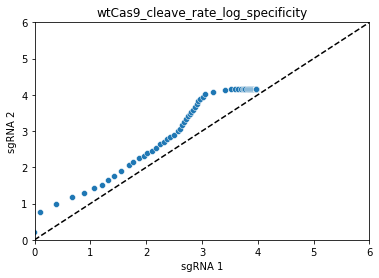

In [20]:
feat = 'wtCas9_cleave_rate_log_specificity'
ax = sns.scatterplot(
    np.percentile(df1[feat], np.arange(1,99,1)),
    np.percentile(df2[feat], np.arange(1,99,1)),
)
ax.set_title(feat)
ax.set_xlabel('sgRNA 1')
ax.set_ylabel('sgRNA 2')
ax.set_xlim(0, -log_fn(1e-1)+5)
ax.set_ylim(0, -log_fn(1e-1)+5)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls='--', color='black')

# Visualization alignments

In [13]:
alns1[100]

Alignment(seqA='GGTCGCAGAGTAGAAA-TACGCAG', seqB='GGTCGCAGAGTAGAAAATACGCAG', score=22.0, start=0, end=24)

In [14]:
alns2[100]

Alignment(seqA='GGTGTACCGTAAG-GTGAATAGTG', seqB='GGTGTACCGTAAGAGTGAATAGTG', score=22.0, start=0, end=24)

In [15]:
# modified from 
# https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

import os, io, random
import string
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

def get_colors(seqs):
    """make colors for bases in sequence"""
    text = [i for s in list(seqs) for i in s]
    clrs =  {'A':'red','T':'green','G':'orange','C':'blue','-':'white'}
    colors = [clrs[i] for i in text]
    return colors


def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = aln[0:2]
    ids = ["gRNA", "target"]    
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, plot_width= plot_width, plot_height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

In [16]:
print(df2.iloc[99])
p = view_alignment(alns2[99], plot_width=300)
pn.pane.Bokeh(p)

sequence                                 GTGATAAGTAGGAATGCCATGTGG
descriptor                                                  12A11
wtCas9_ndABA                                             0.409341
wtCas9_ndABA_unc                                         0.030304
wtCas9_cleave_rate_log                                  -2.334041
wtCas9_cleave_rate_log_unc                               0.114384
Cas9_enh_ndABA                                           0.295856
Cas9_enh_ndABA_unc                                        0.04959
Cas9_enh_cleave_rate_log                                     -5.0
Cas9_enh_cleave_rate_log_unc                              7.40744
Cas9_hypa_ndABA                                          0.133974
Cas9_hypa_ndABA_unc                                       0.01357
Cas9_hypa_cleave_rate_log                                    -5.0
Cas9_hypa_cleave_rate_log_unc                            0.081112
Cas9_HF1_ndABA                                           0.387882
Cas9_HF1_n

Bokeh(Column)

In [17]:
p = view_alignment(alns1[100], plot_width=300)
pn.pane.Bokeh(p)

Bokeh(Column)

In [18]:
try:
    for i in range(len(mats1[100])):
        print((i, mats1[100][i]))
except:
    pass

(0, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(1, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(2, array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(3, array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(4, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(5, array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(6, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(7, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(8, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(9, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(10, array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(11, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(12, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(13, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(14, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(15, array([1., 0., 